# ACF -- Ackerberg, Caves, Frazer

# Summary of the ACF method: 

Consider the "value-added" production function

$$y_{it} = \beta_0 + \beta_k k_{it} + \beta_l l_{it} + \omega_{it} + \epsilon_{it}$$

# Assumptions
* (I): Timing of Input Choices: Firms accumulate capital according to $k_{it} = \kappa\left(k_{it-1}, i_{it-1}\right)$, where investment $i_{it-1}$ is chosen in period $t-1.$ Labor input $l_{it}$ has potentially dynamic implications and is chosen at period $t$, period $t-1$, or period $t-b$ with $b\in (0, 1)$.
* (II): Scalar Unobservable: Firms' intermediate input demand is given by $m_{it} = \tilde f_t\left(k_{it}, l_{it}, \omega_{it}\right)$
* (III): Strict Monotonicity: $\tilde f_t\left(k_{it}, l_{it}, \omega_{it}\right)$ is strictly increasing in $\omega_{it}$. That is, the amount of input demanded is strictly increasing in productivity.

Note that we consider a "value-added" production function, in the sense that the intermediate input $m_{it}$ does not enter the production function to be estimated. 
* One interpretation: Gross output production function is Leontief in the intermediate input, where this intermediate input is proportional to output.

Given these assumptions, following Levinsohn and Petrin, we can invert intermediate input demand to recover the productivity: 

$$\omega_{it}= \tilde f_t^{-1}\left(k_{it}, l_{it}, m_{it}\right).$$

Then, we can substitute into the production function: 

$$
\begin{aligned}
    y_{it} & = \beta_0 + \beta_k k_{it} + \beta_l l_{it} +  f_t^{-1}\left(k_{it}, l_{it}, m_{it}\right) + \varepsilon_{it} \\
    & = \tilde \Phi_t(k_{it}, l_{it}, m_{it}) + \varepsilon_{it}
\end{aligned}
$$

ACF follow LP and treat $f_t^{-1}$ nonparametrically, so, the first three terms $\beta_0, \beta_k, \beta_l$ are not identified and subsumed into $\tilde \Phi_t(k_{it}, l_{it}, m_{it}) = \beta_0+\beta_k k_{it} + \beta_l l_{it} + \omega_{it}$, resulting in the following first-stage moment condition:

$$
E\left[\epsilon_{it} \big| \mathcal I_{it}\right] = E\left[y_{it}- \tilde \Phi_t(k_{it}, l_{it}, m_{it}) \big| \mathcal I_{it}\right]
$$

where $\mathcal I_{it-1}$ is the information set of firm $i$ at time $t-1$. 

From here, we can estimate $\hat{\tilde \Phi}_t$ nonparametrically. 

Next, we can use the second-stage conditional moment

$$
\begin{aligned}
& E[\xi_{it} + \varepsilon_{it} \big| \mathcal I_{it-1}] = \\
& E\left[y_{it} - \beta_0 - \beta_k k_{it} - \beta_l l_{it} - g\left(\hat{\tilde \Phi}_{t-1}(k_{it-1}, l_{it-1}, m_{it-1}) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\bigg| \mathcal I_{it-1}\right] = 0
\end{aligned}
$$

where the function $g(\cdot) = E[\omega_{it}|\omega_{it-1}]$ comes from:

$$
\omega_{it} = E[\omega_{it}|\mathcal I_{it-1}] + \xi_{it} = E[\omega_{it}|\omega_{it-1}]+\xi_{it} = g(\omega_{it-1}) + \xi_{it}
$$

# Identification Procedure:
For a simple example, suppose $\omega_{it} = \rho \omega_{it-1} + \xi_{it}.$ Then
$g(x) = E[x|\omega_{it-1}] = \rho \omega_{it-1}.$ Assume labor is chosen after time $t-1$. Then the estimation procedure is: 

## (1) Regress $y_{it}$ on $\left(k_{it}, l_{it}, m_{it}\right)$ nonparametrically, or using a high-order polynomial, to obtain $\hat{\tilde \Phi}_t\left(k_{it}, l_{it}, m_{it}\right).$

We do this for every period to get a sequence of functions of $(k, l, m).$ These will be plugged in for $\Phi$ in the next step. 

## (2) Use the following four moment conditions to estimate the parameters $\left(\beta_0, \beta_k, \beta_l, \rho\right):$

$$
E\left[\left(y_{it} - \beta_0 - \beta_k k_{it} - \beta_l l_{it} - \rho\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\right) \otimes \begin{pmatrix} 1 \\ k_{it} \\ l_{it-1} \\ \tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) \\ \end{pmatrix} \right] = 0
$$

Here's where we use GMM. 

# Load in the data


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from itertools import combinations_with_replacement, chain

In [6]:
filename = "../PS3_data_changedtoxlsx.xlsx"
cols_to_keep = [0, 2, 3, 4, 5, 6, 40, 43, 44, 48]
new_names = ["year", "firm_id", "obs", "ly", "s01", "s02", "lc", "ll", "lm", "lwl"]
#Load in the data
df = pd.read_excel(filename, usecols=cols_to_keep)
df.columns = new_names

#Keep industry 1 only
df=df[df['s01']==1]


DATA = df[['lc', 'll', 'lm']]
y = df[['ly']]
#Convert to arrays
y = y.to_numpy()
DATA = DATA.to_numpy()

# First step of coding: Write functions for the estimation of $\tilde \Phi_t.$

In [8]:
def poly_terms(n_features, degree):
    #This thing creates an iterator structure of tuples, used to create polynomial interaction terms. 
    #It looks something like this
    #(0,)
    #(1,)
    #(2,)
    #(0, 0)
    #(0, 1), etc 
    polynomial_terms = chain(
        *(combinations_with_replacement(range(n_features), d) for d in range(1, degree+1))
    )
    return(polynomial_terms)

def fit_phi_poly(y, DATA, degree):
    #Get number of observations (n) and number of independent variables (k)
    #y = y.to_numpy()
    #DATA = DATA.to_numpy()
    if DATA.ndim == 1:
        DATA.reshape(1, -1)
    # Get the number of samples (n) and number of features (m) from X
    n_samples, n_features = DATA.shape
    
    # Start with a column of ones for the intercept term
    X_poly = np.ones((n_samples, 1))

    #Create iterator used to construct polynomial terms
    polynomial_terms = poly_terms(n_features, degree)
    
    # Generate polynomial terms and interaction terms up to 4th degree
    for terms in  polynomial_terms:  # For degrees 1 to 4
            X_poly = np.hstack((X_poly, np.prod(DATA[:, terms], axis=1).reshape(-1, 1)))
    
    # Compute the coefficients using the normal equation: beta = (X.T * X)^(-1) * X.T * y
    XT_X = X_poly.T @ X_poly
    XT_X_inv = np.linalg.inv(XT_X)
    XT_y = X_poly.T @ y
    beta = XT_X_inv @ XT_y

    return beta

#Function to evaluate the fitted values of the polynomial regression
def eval_phi_poly(DATA, degree, beta):

    if DATA.ndim == 1:
        DATA = DATA.reshape(1, -1)
    # Get the number of samples (n) and number of features (m) from X
    n_samples, n_features = DATA.shape
    # Create polynomial terms iterator
    polynomial_terms = poly_terms(n_features, degree)

    # Start with a column of ones for the intercept term
    X_poly = np.ones((n_samples, 1))
    
    # Generate polynomial terms and interaction terms up to 4th degree
    for terms in  polynomial_terms:  # For degrees 1 to 4
            X_poly = np.hstack((X_poly, np.prod(DATA[:, terms], axis=1).reshape(-1, 1)))
    
    yhat = X_poly@beta
    
    # Generate polynomial terms and interaction terms up to 4th degree
    #yhat = np.zeros((n_samples,1))
    #for terms in  polynomial_terms:  # For degrees 1 to 4
    #        yhat = np.sum(yhat, beta*np.prod(DATA[:, terms], axis=1).reshape(-1, 1))

    return yhat

In [9]:
#Testing
xtest = np.arange(1, 13).reshape(-1, 1)
ytest = xtest**2

betatest = fit_phi_poly(ytest, xtest, 4)
yhattest = eval_phi_poly(xtest, 4, betatest)

In [10]:
degree= 3
beta = fit_phi_poly(y, DATA, degree)
yhat = eval_phi_poly(DATA, degree, beta)

## Actual by predicted plot for my polynomial approximation of $\Phi$, run on the entire sample

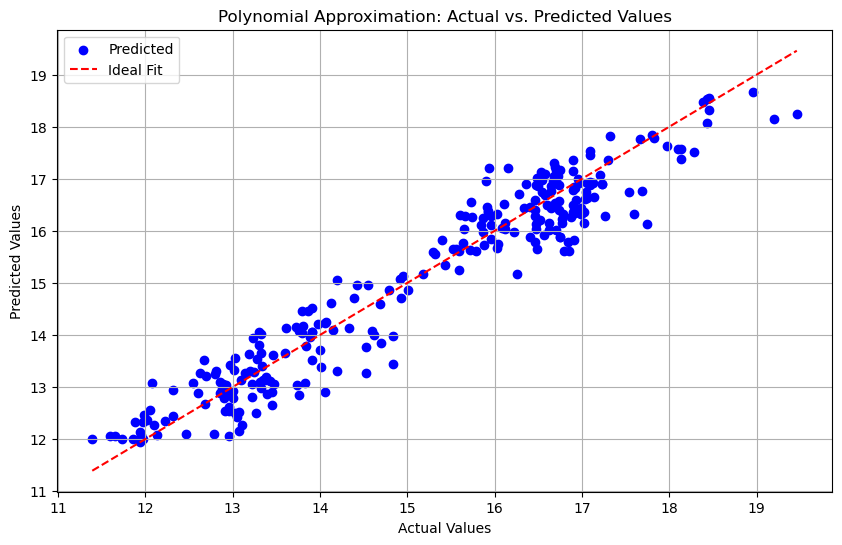

In [12]:
# Example data (replace these with your actual y and yhat values)
# Create a scatter plot for actual vs. predicted
plt.figure(figsize=(10, 6))
plt.scatter(y, yhat, color='blue', label='Predicted', marker='o')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Polynomial Approximation: Actual vs. Predicted Values')
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Next step: for each time t, estimate the polynomial fit. Store in a mapping for time, k, l, m. 

## Function for evaluating the Phi function

In [15]:
def fit_phi_poly_years(df, degree):

    years = np.unique(df[["year"]])
    
    #Dictionary for storing the polynomial fits associated with each year
    phi_beta_dict = {}
    
    for t in years: 
        #Get data for the current year
        df_t = df[df["year"] == t]
        y_t = df_t[["ly"]].to_numpy()
        DATA_t = df_t[['lc', 'll', 'lm']].to_numpy()
        #fit the polynomial
        beta_t = fit_phi_poly(y_t, DATA_t, degree)
        phi_beta_dict[t] = beta_t

    return phi_beta_dict


def phi_wrapper(row, xvars, phi_beta_dict, degree):
    DATA_row = row[xvars].to_numpy()
    t = row['year']
    beta = phi_beta_dict[t] #Get the beta fit to the particular year
    Phihat = eval_phi_poly(DATA_row, degree, beta).item()

    return Phihat

#Year-by-year --- Function to evaluate the fitted values of the polynomial regression
def eval_phi_poly_years(df, xvars, degree):
    #Year-by-year, fit the Phi function 
    phi_beta_dict = fit_phi_poly_years(df, degree)
    firms = np.unique(df[["firm_id"]])    
    df_phi = df.apply(phi_wrapper, axis = 1, args = (xvars, phi_beta_dict, degree) ).to_numpy()
    
    return df_phi

In [16]:
#phi_beta_dict = fit_phi_poly_years(df, degree)
df_phi = eval_phi_poly_years(df, xvars = ['lc', 'll', 'lm'], degree=2) #Higher degree than 2 and it tends to be overfit
#Add into the dataframe
df["Phi"] = df_phi

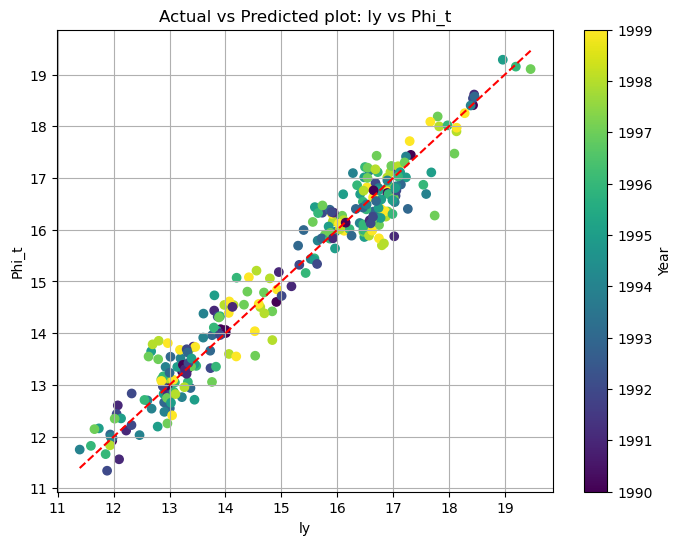

In [17]:
#Actual vs Predicted plot
# Assuming df is a structured NumPy array
actual_values = df['ly']     # Extract the actual values
predicted_values = df['Phi'] # Extract the predicted values
years = df['year']

# Create the plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(actual_values, predicted_values, c=years, cmap='viridis', label='Predicted vs Actual')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')

# Add a color bar to represent the year scale
cbar = plt.colorbar(scatter)
cbar.set_label('Year')

# Add labels and title
plt.xlabel('ly')
plt.ylabel('Phi_t')
plt.title('Actual vs Predicted plot: ly vs Phi_t')
plt.grid(True)

# Show the plot
plt.show()

## Now, we have our polynomial fit. Time to start coding GMM
We have four parameters: $\beta_0$, $\beta_k$, $\beta_l$, and $\rho$.
Each of the four moment conditions state that 
$$E\left[\left(\xi_{it}+\epsilon_it\right)\left(Z\right)\right] = 0,$$ where $Z$ is one of the elements of the firm's information set at time $t-1.$

## Get a function that evaluates the objective function of the GMM estimator

The objective function minimizes the weighted errors of the moment restrictions with respect to parameters $\theta$. It is

$$
\min_\theta \left\{     \mathbf e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)^\intercal_{1\times 4} \times\left(\mathbb W_{4\times 4}\right) \times      \mathbf e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)_{4\times 1} \right\} \equiv
$$



$$
\min_\theta \left\{   \left[ \begin{pmatrix} 1^\intercal \\ \operatorname{vec}(k_{it})^\intercal \\ \operatorname{vec}(l_{it-1})^\intercal \\ \operatorname{vec}\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right)\right)^\intercal \\ \end{pmatrix} \cdot h(\theta, \mathbf y, \mathbf k, \mathbf l)\right]^\intercal_{1\times 4} \times  \left(\mathbb W_{4\times 4}\right) \times \left[ \begin{pmatrix} 1^\intercal \\ \operatorname{vec}(k_{it})^\intercal \\ \operatorname{vec}(l_{it-1})^\intercal \\ \operatorname{vec}\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right)\right)^\intercal \\ \end{pmatrix} \cdot  h(\theta, \mathbf y, \mathbf k, \mathbf l)  \right]_{4\times 1} \right\}, 
$$


which is a scalar, where

$$
h(\theta, \mathbf y, \mathbf k, \mathbf l) = \operatorname{vec}\left(y_{it} - \beta_0 - \beta_k k_{it} - \beta_l l_{it} - \rho\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\right).
$$

In words, we take the dot product of the $h$ function with each of the vectors in the big pmatrix, and get four moment conditions in total. 


In [73]:
#Extracts the relevant arguments for ACF estimation from the data frame
def format_args_ACF(df):
    #new dataframe
    #Getting data in the correct format
    y = df['ly'].to_numpy()
    Phi = df['Phi'].to_numpy()
    Phiprev = df['Phi'].shift(1).to_numpy()
    k = df['lc'].to_numpy()
    kprev =  df['lc'].shift(1).to_numpy()
    l = df['ll'].to_numpy()
    lprev =  df['ll'].shift(1).to_numpy()
    args_ACF = (y, Phi, Phiprev, k, kprev, l, lprev)
    return args_ACF

#Calculates the error term, h(theta, y, k, l)
def moment_error_ACF(theta, args_ACF):
    #get the variables we need
    y, Phi, Phiprev, k, kprev, l, lprev = args
    #theta = [beta_0, beta_k, beta_l, rho]
    value = (y - theta[0] - theta[1]*k - theta[2]*l - 
             theta[3]*(Phiprev - theta[0] - theta[1]*kprev - theta[2]*lprev) )
    #remove nans (associated with the lag) -- this is ok because we're just using this vector as part of a dot product. 
    value = np.nan_to_num(value, nan = 0)
    return value

def moment_ex_restrictions_ACF(args_ACF):
    y, Phi, Phiprev, k, kprev, l, lprev = args
    #Moment conditions include exogeneity restrictions for 1, k_{it}, l_{it-1}, and Phi. 
    #Put them all in one matrix for easy access, called Vexc (short for vectors for exogeneity restrictions)
    #Replace all nans with zeros -- this is ok, because we're just taking a dot product over each row of this matrix, and want to remove the nans
    Vex = np.nan_to_num(np.vstack([np.ones(len(k)), k, lprev, Phiprev]),  nan=0)
    return Vex

def gmm_obj_ACF(theta, args, Vex, W):
    #Arguments
    y, Phi, Phiprev, k, kprev, l, lprev = args
    #Get the vector h(theta, y, k, l)
    moment_error = moment_error_ACF(theta, args_ACF)
    #Calculate the "error" -- exogenous terms (dotproduct) h(theta, y, k, l)
    err = Vex@moment_error
    #Calculate the weighted sum of the error using the weight matrix, W
    obj = err.T@W@err
    return obj, err

## Quick test -- evaluating the GMM objective function at $\theta = \mathbf 1$. 

In [85]:
#Run GMM
#Initial guess for parameters beta_0, beta_k, beta_l, rho
theta0 = np.array([1,1,1,1])
#Weight matrix -- use the identity for now. 
W0 = np.eye(4)
#(1) Get the arguments used in ACF from the data frame
args_ACF = format_args_ACF(df)
#(2) Get matrix of variables used in exogeneity restrictions
Vex = moment_ex_restrictions_ACF(args_ACF)
#Evaluate the GMM error
obj, err = gmm_obj_ACF(theta0, args_ACF, Vex, W0)
err
obj

1633287.0005913512

## Next step --  need to calculate the gradient to perform optimization. 

The gradient of the GMM objective function with respect to the parameters $\theta$ is
$$
\nabla_{\theta}  \mathbf e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)^\intercal_{1\times 4} \times\left(\mathbb W_{4\times 4}\right) \times      \mathbf e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)_{4\times 1} \equiv 2\left[\frac{\partial e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)}{\partial \theta}\right]_{4\times 4}\times\left(\mathbb W_{4\times 4}\right) \times      \mathbf e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)_{4\times 1}
$$

where 

$$
\left[\frac{\partial e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)}{\partial \theta}\right]_{4\times 4} = \begin{bmatrix} 
1^\intercal\frac{ \mathbf \partial h(\theta, \mathbf y, \mathbf k, \mathbf l)}{\partial \beta_0} & 1^\intercal\frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)}{\partial \beta_k} & 1^\intercal\frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)}{\partial \beta_l} & 1^\intercal\frac{ \mathbf \partial h(\theta, \mathbf y, \mathbf k, \mathbf l)}{\partial \rho} \\
\operatorname{vec}(k_{it})^\intercal\frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_0} &\operatorname{vec}(k_{it})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_k} &\operatorname{vec}(k_{it})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_l} &\operatorname{vec}(k_{it})^\intercal  \frac{\partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \rho} \\
\operatorname{vec}(l_{it-1})^\intercal\frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_0} &\operatorname{vec}(l_{it-1})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_k} &\operatorname{vec}(l_{it-1})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_l} &\operatorname{vec}(l_{it-1})^\intercal  \frac{\partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \rho} \\
\operatorname{vec}(\Phi_{it-1})^\intercal\frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_0} &\operatorname{vec}(\Phi_{it-1})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_k} &\operatorname{vec}(\Phi_{it-1})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_l} &\operatorname{vec}(\Phi_{it-1})^\intercal  \frac{\partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \rho} 
\end{bmatrix} 
$$

$$
\equiv \begin{bmatrix} 1^\intercal \\ \operatorname{vec}(k_{it})^\intercal \\ \operatorname{vec}(l_{it-1})^\intercal  \\ \operatorname{vec}(\Phi_{it-1})^\intercal \end{bmatrix}_{4\times n} \begin{bmatrix} \frac{\partial \mathbf h}{\partial \beta_0} & \frac{\partial \mathbf h}{\partial \beta_k} & \frac{\partial \mathbf h}{\partial \beta_l} & \frac{\partial \mathbf h}{\partial \rho}  \end{bmatrix}_{4x4}
$$


is the Jacobian of the error function with respect to $\theta = \left(\beta_0, \beta_k, \beta_l, \rho\right)$. 

We already have code to calculate the first matrix here -- it is just called ```Vex```, "vectors of exogeneity restrictions."
It remains to calculate the partial derivatives in the second matrix.

$$
\mathbf h = \operatorname{vec}\left(y_{it} - \beta_0 - \beta_k k_{it} - \beta_l l_{it} - \rho\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\right)
$$

$$
\frac{\partial \mathbf h}{\partial \beta_0} =  -1 + \rho
$$
$$
\frac{\partial \mathbf h}{\partial \beta_k} = -\operatorname{vec}(k_{it}) + \rho\operatorname{vec}(k_{it-1})
$$
$$
\frac{\partial \mathbf h}{\partial \beta_l} = -\operatorname{vec}(l_{it}) + \rho\operatorname{vec}(l_{it-1})
$$
$$
\frac{\partial \mathbf h}{\partial \rho} = \operatorname{vec}\left( - \left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\right) 
$$





In [195]:
def jacobian_ACF(theta, args, Vex):
    y, Phi, Phiprev, k, kprev, l, lprev = args
    
    #Partial derivatives of h
    Dh = np.nan_to_num(np.vstack(
        [
         np.ones(len(k))*(-1 + theta[3]), #dh/dbeta0  
         -k + theta[3]*kprev,             #dh/dbetak
         -l + theta[3]*lprev,             #dh/dbetal
         -(Phiprev - theta[0] - theta[1]*kprev - theta[2]*lprev)
        ]
    ),  nan=0).T

    Jac = Vex@Dh
    return Jac

def gradient_ACF(theta, args, Vex, W):

In [199]:
#testing
Jac = jacobian_ACF(theta0, args_ACF, Vex)
Jac

array([[ 0.00000000e+00, -2.49178000e-01,  1.03805600e-01,
         1.12787414e+03],
       [ 0.00000000e+00, -1.62034904e+03,  4.64043979e+00,
         1.34412620e+04],
       [ 0.00000000e+00, -5.09561155e+00,  1.10848482e+00,
         8.42660627e+03],
       [ 0.00000000e+00,  3.27921720e+02,  4.48145719e-01,
         1.76339403e+04]])

## Now, use a minimization routine, with the Jacobian, to optimize for theta. 

In [ ]:
results_grad = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, jac=criterion_gradient, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


# 1: Reviewing Generalized Method of Moments (GMM)

## GMM Definition 

- GMM first formalized by Hansen (1982). Main strength is that the econometrician can **remain completely agnostic as to the distribution of the random variables in the DGP**; just need as many moment conditions from the data as he has parameters to estimate.

- A *moment* of the data is broadly defined as any statistic that summarizes the data to some degree. A data moment could be as narrow as an individual observation from the data or as broad as the sample average. GMM estimates the parameters of a model or data generating process to make the model moments as close as possible to the corresponding data moments. 

- Let $m(x)$ be an $R\times 1$ vector of moments from the real world data $x$. And let $x$ be an $N\times K$ matrix of data with $K$ columns representing $K$ variables and $N$ observations. Let the model DGP be characterized as $F(x,\theta)$. Define $m(x|\theta)$ as a vector of $R$ moments from the model that correspond to the real-world moment vector $m(x)$.

$$ \hat{\theta}_{GMM}=\theta:\quad \min_{\theta}\: ||m(x|\theta) - m(x)|| $$

## GMM Definition

- The most widely studied and used distance metric in GMM estimation is the $L^2$ norm or the sum of squared errors in moments. Define the moment error function $e(x|\theta)$ as either the percent difference in the vector of model moments from the data moments or the simple difference.

$$ e(x|\theta) \equiv \frac{m(x|\theta) - m(x)}{m(x)} \quad\text{or}\quad m(x|\theta) - m(x)$$

- Percent deviation puts all the moments in the same units, which helps make sure that no moments receive unintended weighting simply due to its units. However, percent deviations become computationally problematic when the data moments are zero or close to zero. In that case, you would use a simple difference.

$$ \hat{\theta}_{GMM}=\theta:\quad \min_{\theta}\:e(x|\theta)^T \, W \, e(x|\theta) $$

- Where $W$ is a $R\times R$ weighting matrix in the criterion function. 

## The Weighting Matrix (W)

The optimal weighting matrix is the inverse variance covariance matrix of the moments at the optimal parameter values,

$$ W^{opt} \equiv \Omega^{-1}(x|\hat{\theta}_{GMM}) $$

where $\Omega(x|\theta)$ is the variance covariance matrix of the moment condition errors $E(x|\theta)$ from each observation in the data (to be defined below). The intuition for using the inverse variance covariance matrix $\Omega^{-1}$ as the optimal weighting matrix is the following. You want to downweight moments that have a high variance, and you want to weight more heavily the moments that are generated more precisely.

Notice that this definition of the optimal weighting matrix **is circular**. This means that one has to use some kind of iterative fixed point method to find the true optimal weighting matrix $W^{opt}$. 

## The identity matrix (W = I)
Many times, you can get away with just using the identity matrix as your weighting matrix $W = I$. This changes the criterion function to a simple sum of squared error functions such that each moment has the same weight.

$$ \hat{\theta}_{GMM}=\theta:\quad \min_{\theta}\:e(x|\theta)^T \, e(x|\theta) $$

If the problem is well conditioned and well identified, then your GMM estimates $\hat{\theta}_{GMM}$ will not be greatly affected by this simplest of weighting matrices.

## Two-step variance covariance estimator of W
The most common method of estimating the optimal weighting matrix for GMM estimates is the two-step variance covariance estimator. The name "two-step" refers to the two steps used to get the weighting matrix.

The first step is to estimate the GMM parameter vector $\hat{\theta}_{1,GMM}$ using the simple identity matrix as the weighting matrix $W = I$.

$$ \hat{\theta}_{1, GMM}=\theta:\quad \min_{\theta}\:e(x|\theta)^T \, I \, e(x|\theta) $$

You then use the errors from each observation in the data $E(x|\theta)$ that generated the error vector $e(x|\theta)$, which data matrix is $R\times N$ and if summed across the rows gives the error vector. When the errors are simple differences the $E(x|\theta)$ matrix is the following,

$$ E(x|\theta) =
  \begin{bmatrix}
    m_1(x|\theta) - m_1(x_1) & m_1(x|\theta) - m_1(x_2) & ... & m_1(x|\theta) - m_1(x_N) \\
    m_2(x|\theta) - m_2(x_1) & m_2(x|\theta) - m_2(x_2) & ... & m_2(x|\theta) - m_2(x_N) \\
    \vdots & \vdots & \ddots & \vdots \\
    m_R(x|\theta) - m_R(x_1) & m_R(x|\theta) - m_R(x_2) & ... & m_R(x|\theta) - m_R(x_N) \\
  \end{bmatrix} $$

where $m_r(x_i)$ is a function associated with the $r$th moment and the $i$th data observation.


We use the $E(x|\theta)$ data matrix and the Step 1 GMM estimate $e(x|\hat{\theta}_{1,GMM})$ to get a new estimate of the variance covariance matrix.

$$ \hat{\Omega}_2 = \frac{1}{N}E(x|\hat{\theta}_{1,GMM})\,E(x|\hat{\theta}_{1,GMM})^T $$

This is simply saying that the $(r,s)$-element of the estimator of the variance-covariance matrix of the moment vector is the following.

$$\hat{\Omega}_{r,s} = \frac{1}{N}\sum_{i=1}^N\Bigl[m_r(x|\theta) - m_{r}(x_i)\Bigr]\Bigl[ m_s(x|\theta) - m_s(x_i)\Bigr] $$

The optimal weighting matrix is the inverse of the two-step variance covariance matrix.

$$ \hat{W}^{two-step} \equiv \hat{\Omega}_2^{-1} $$

Lastly, re-estimate the GMM estimator using the optimal two-step weighting matrix.

$$ \hat{\theta}_{2, GMM}=\theta:\quad \min_{\theta}\:e(x|\theta)^T \, \hat{W}^{two-step} \, e(x|\theta) $$

$\hat{\theta}_{2, GMM}$ is called the two-step GMM estimator.

# 2: GMM Strengths/Applications 

### MLE Strenths
- More statistical significance. In general, MLE provides more statistical significance for parameter estimates than does GMM. This comes from the strong distributional assumptions that are necessary for the ML estimates.
- ML estimates are less sensitive to parameter or model normalizations than are GMM estimates.
- ML estimates have nice small sample properties. ML estimates have less bias and more efficiency with small data samples than GMM estimates in many cases.

### MLE Weaknesses
- MLE requires **strong distributional assumptions**. For MLE, **the data generating process (DGP) must be completely specified**. This assumes a lot of knowledge about the DGP. This assumption is likely almost always wrong.

### GMM Strengths
- GMM allows for **most flexible identification**. GMM estimates can be identified by any set of moments from the data as long as you have at least as many moments as you have parameters to estimate and that those moments are independent enough to identify the parameters. (And the parameters are independent enough of each other to be separately identified.)
- Good large sample properties. The GMM estimator is strongly consistent and asymptotically normal. GMM will likely be the best estimator if you have a lot of data.
- GMM requires minimal assumptions about the DGP. In GMM, you need not specify the distributions of the error terms in your model of the DGP. This is often a strength, given that most error are not observed and most models are gross approximations of the true DGP.

### GMM Weaknesses
- GMM estimates are usually less statistically significant than ML estimates. This comes from the minimal distributional assumptions. GMM parameter estimates usually are measured with more error.
- GMM estimates can be sensitive to normalizations of the model or parameters.
- GMM estimates have bad small sample properties. GMM estimates can have large bias and inefficiency in small samples.

## GMM estimation of the linear model (linear regression)

Consider the following econometric model...

$$ y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \varepsilon_i \quad\text{where}\quad E\left[\varepsilon_i\right] = 0 $$

In the econometric model example above, there are three parameters to be estimated $(\beta_0, \beta_1, \beta_2)$. We need at least three independent moments to identify these parameters. The first moment we can use is the assumption that the unconditional expectation of the error terms is zero. This has an empirical counterpart that the sample mean of the error terms should be zero.

$$ \text{(Theoretical moment 1)}\quad E[\varepsilon_i] = 0 \quad\Rightarrow\quad E\left[y_i - \beta_0 - \beta_1 x_{1,i} - \beta_2 x_{2,i}\right]=0 $$
$$ \text{(Empirical moment 1)}\qquad\qquad\qquad\:\:\: \frac{1}{N}\sum_{i=1}^N\left[y_i - \beta_0 - \beta_1 x_{1,i} - \beta_2 x_{2,i}\right]=0 $$

$$ \text{(Theoretical moment 2)}\quad E[\varepsilon_i x_{1,i}] = 0 \quad\Rightarrow\quad E\Bigl[\left(y_i - \beta_0 - \beta_1 x_{1,i} - \beta_2 x_{2,i}\right)x_{1,i}\Bigr]=0 $$
$$ \text{(Empirical moment 2)}\qquad\qquad\qquad\qquad \frac{1}{N}\sum_{i=1}^N\Bigl[\left(y_i - \beta_0 - \beta_1 x_{1,i} - \beta_2 x_{2,i}\right)x_{1,i}\Bigr]=0 $$

$$ \text{(Theoretical moment 3)}\quad E[\varepsilon_i x_{2,i}] = 0 \quad\Rightarrow\quad E\Bigl[\left(y_i - \beta_0 - \beta_1 x_{1,i} - \beta_2 x_{2,i}\right)x_{2,i}\Bigr]=0 $$
$$ \text{(Empirical moment 3)}\qquad\qquad\qquad\qquad \frac{1}{N}\sum_{i=1}^N\Bigl[\left(y_i - \beta_0 - \beta_1 x_{1,i} - \beta_2 x_{2,i}\right)x_{2,i}\Bigr]=0 $$

You can derive that this estimation is equivalent to OLS; that is, the $\hat{\beta}$ that minimizes the objective function produced by these 3 moments (with identity weighting) will $= \hat{beta}_{OLS}$. But it's worth differentiating with the MLE approach; here we are imposing A) that we have correctly specified the model, B) that error terms have mean 0 C) that our independent variables are exogenous. We aren't fully specifying the DGP; **no distribution imposed on error terms**. 

# 3. Example: Fitting a truncated normal to intermediate macroeconomics test scores

Example code from Professor Evans. The setup is estimating the truncated normal distribution of intermediate macroeconomics test scores. Note that this distribution is defined by two parameters: $\mu$ and $\sigma$. So our problem will be generating good estimates of these parameters via GMM.

In [1]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')


import requests
from IPython.display import Image

/var/folders/2d/mfd3fp6d6d38ky2jff3fc9bc0000gn/T/ipykernel_39576/1546364804.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = matplotlib.cm.get_cmap('summer')


## 3.1: Two moments, identity weighting matrix

What moments should we use? Obvious initial choice: let's try the mean and variance of the data. These two statistics of the data are defined by:

$$ mean(scores_i) = \frac{1}{N}\sum_{i=1}^N scores_i $$

$$ var(scores_i) = \frac{1}{N}\sum_{i=1}^{N} \left(scores_i - mean(scores_i)\right)^2 $$

So the data moment vector $m(x)$ for GMM is the following.

$$ m(scores_i) \equiv \begin{bmatrix} mean(scores_i) \\ var(scores_i) \end{bmatrix} $$

And the model moment vector $m(x|\theta)$ for GMM is the following.

$$ m(scores_i|\mu,\sigma) \equiv \begin{bmatrix} mean(scores_i|\mu,\sigma) \\ var(scores_i|\mu,\sigma) \end{bmatrix} $$

Define the error vector as the vector of percent deviations of the model moments from the data moments.

$$ e(scores_i|\mu,\sigma) \equiv \frac{m(scores_i|\mu,\sigma) - m(scores_i)}{m(scores_i)} $$

The GMM estimator for this moment vector is the following.

$$ (\hat{\mu}_{GMM},\hat{\sigma}_{GMM}) = (\mu,\sigma):\quad \min_{\mu,\sigma} e(scores_i|\mu,\sigma)^T \, W \, e(scores_i|\mu,\sigma) $$

In [2]:
# Download and save the data file Econ381totpts.txt
url = ('https://raw.githubusercontent.com/rickecon/Notebooks/' +
       'master/GMM/data/Econ381totpts.txt')
data_file = requests.get(url, allow_redirects=True)
open('data/Econ381totpts.txt', 'wb').write(data_file.content)

# Load the data as a NumPy array
pts = np.loadtxt('data/Econ381totpts.txt')

In [3]:
# Define function that generates values of a normal pdf
def trunc_norm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the normal pdf with mean mu and standard
    deviation sigma. If the cutoff is given, then the PDF values are
    inflated upward to reflect the zero probability on values above the
    cutoff. If there is no cutoff given, this function does the same
    thing as sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.norm.cdf(cut_lb, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.norm.cdf(cut_ub, loc=mu, scale=sigma) -
                       sts.norm.cdf(cut_lb, loc=mu, scale=sigma))
            
    pdf_vals    = ((1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (xvals - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

Now let's define a criterion function that takes as inputs the parameters and the estimator for the weighting matrix $\hat{W}$.

In [4]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data


def model_moments(mu, sigma, cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * trunc_norm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_norm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, var_model


def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

Now we can perform the GMM estimation. Let's start with the identity matrix as our estimate for the optimal weighting matrix $W = I$.

In [5]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 400
sig_init = 60
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, 0.0, 450.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results

criterion(results.x, *gmm_args)

mu_GMM1= 622.0452985633967  sig_GMM1= 198.72061651029907


array([[2.79912227e-18]])

In [6]:
mean_data, var_data = data_moments(pts)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 450.0)
err1 = err_vec(pts, mu_GMM1, sig_GMM1, 0.0, 450.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err1)
results

Mean of points = 341.90869565217395 , Variance of points = 7827.997292398056
Mean of model = 341.90869509312074 , Variance of model = 7827.997289623955
Error vector= [-1.63509502e-09 -3.54381921e-10]


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2.799122270211071e-18
        x: [ 6.220e+02  1.987e+02]
      nit: 19
      jac: [-9.684e-14  3.544e-13]
     nfev: 87
     njev: 29
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

Let's plot the PDF implied by these results against the histogram.

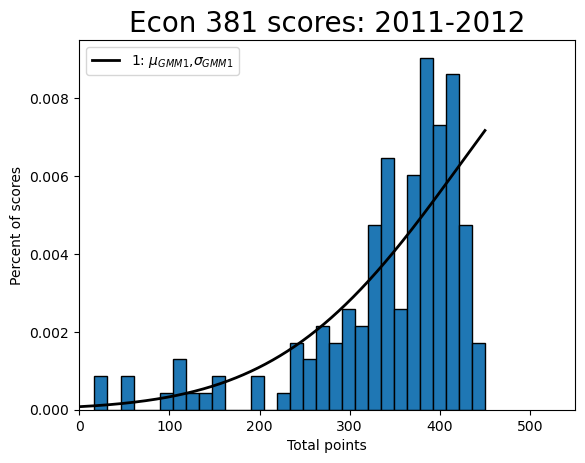

In [7]:
# Plot the histogram of the data
num_bins = 30
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title('Econ 381 scores: 2011-2012', fontsize=20)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent of scores')
plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 450, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 450),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

Let's see what the criterion function looks like for different values of $\mu$ and $\sigma$.

/var/folders/2d/mfd3fp6d6d38ky2jff3fc9bc0000gn/T/ipykernel_39576/1815808032.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crit_vals[mu_ind, sig_ind] = \


Text(0.5, 0, 'Crit. func.')

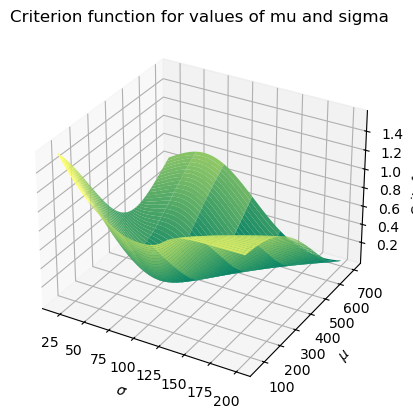

In [8]:
# Note that this will take a few minutes because the intgr.quad() commands
# are a little slow
mu_vals = np.linspace(60, 700, 50)
sig_vals = np.linspace(20, 200, 50)
# mu_vals = np.linspace(540, 572, 50)
# sig_vals = np.linspace(170, 182, 50)
crit_vals = np.zeros((50, 50))
for mu_ind in range(50):
    for sig_ind in range(50):
        crit_vals[mu_ind, sig_ind] = \
            criterion(np.array([mu_vals[mu_ind], sig_vals[sig_ind]]),
                      pts, 0.0, 450.0, W_hat)

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(sig_mesh, mu_mesh, crit_vals, rstride=8,
                cstride=1, cmap=cmap1)
ax.set_title('Criterion function for values of mu and sigma')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\mu$')
ax.set_zlabel(r'Crit. func.')

Let's compute the GMM estimator for the variance-covariance matrix $\hat{\Sigma}_{GMM}$ of our GMM estimates $\hat{\theta}_{GMM}$ using the equation above based on the Jacobian $d(x|\hat{\theta}_{GMM})$ of the moment error vector $e(x|\hat{\theta}_{GMM})$ from the criterion function at the estimated (optimal) parameter values $\hat{\theta}_{GMM}$. We first write a function that computes the Jacobian $d(x|\hat{\theta}_{GMM})$.

In [9]:
def Jac_err2(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    '''
    This function computes the Jacobian matrix of partial derivatives of the R x 1 moment
    error vector e(x|theta) with respect to the K parameters theta_i in the K x 1 parameter vector
    theta. The resulting matrix is R x K Jacobian.
    '''
    Jac_err = np.zeros((2, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = \
        ((err_vec(xvals, mu + h_mu, sigma, cut_lb, cut_ub, simple) -
          err_vec(xvals, mu - h_mu, sigma, cut_lb, cut_ub, simple)) / (2 * h_mu)).flatten()
    Jac_err[:, 1] = \
        ((err_vec(xvals, mu, sigma + h_sig, cut_lb, cut_ub, simple) -
          err_vec(xvals, mu, sigma - h_sig, cut_lb, cut_ub, simple)) / (2 * h_sig)).flatten()
    
    return Jac_err

In [10]:
N = pts.shape[0]
d_err2 = Jac_err2(pts, mu_GMM1, sig_GMM1, 0.0, 450.0, False)
print(d_err2)
print(W_hat)
SigHat2 = (1 / N) * lin.inv(d_err2.T @ W_hat @ d_err2)
print(SigHat2)
print('Std. err. mu_hat=', np.sqrt(SigHat2[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHat2[1, 1]))

[[ 0.00057977 -0.00191677]
 [-0.00244916  0.00973172]]
[[1. 0.]
 [0. 1.]]
[[680416.39876855 172529.76088239]
 [172529.76088239  43810.63730259]]
Std. err. mu_hat= 824.8735653229239
Std. err. sig_hat= 209.3099073206877


Similar to the ML problem, it looks like the criterion function is roughly equal for a specific portion increase of $\mu$ and $\sigma$ together. That is, with these two moments probably have a correspondence of values of $\mu$ and $\sigma$ that give roughly the same criterion function value. This issue has two possible solutions.

1. Maybe we need the two-step variance covariance estimator to calculate a "more" optimal weighting matrix $W$.
2. Maybe our two moments aren't very good moments for fitting the data.

I'm going to skip (1), though those interested can see the code in the original notebook. Let's try (2)...

## 3.2: Four moments, identity weighting matrix
Using a better weighting matrix didn't improve our estimates or fit very much it did improve the standard errors of our estimates. To get the right fit, we might need to choose different moments. Let's try an overidentified model $K<R$, where we estimate $\mu$ and $\sigma$ of the truncated normal distribution $K=2$ using the following four moments $R=4$.

1. The percent of observations greater than 430 (between 430 and 450)
2. The percent of observations between 320 and 430
3. The percent of observations between 220 and 320
4. The percent of observations less than 220 (between 0 and 220)

In [11]:
def data_moments4(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3, binpct_4).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 220
    bpct_2_dat = scalar in [0, 1], percent of observations
                 220 <= x < 320
    bpct_3_dat = scalar in [0, 1], percent of observations
                 320 <= x < 430
    bpct_4_dat = scalar in [0, 1], percent of observations
                 430 <= x <= 450

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3, bpct_4
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 220].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=220) & (xvals < 320)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=320) & (xvals < 430)].shape[0] /
                  xvals.shape[0])
    bpct_4_dat = xvals[xvals >= 430].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat, bpct_4_dat


def model_moments4(mu, sigma, cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    This function computes the four model moments for GMM
    (binpct_1, binpct_2, binpct_3, binpct_4).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bp_1_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_1_mod
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bp_2_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_2_mod
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3
    bp_3_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_3_mod
    bpct_4_mod = scalar in [0, 1], percent of model observations in
                 bin 4
    bp_4_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_4_mod
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: trunc_norm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 220)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 220, 320)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 320, 430)
    (bpct_4_mod, bp_4_err) = intgr.quad(xfx, 430, 450)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod


def err_vec4(xvals, mu, sigma, cut_lb, cut_ub, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments4()
        model_moments4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat, bpct_4_dat = \
        data_moments4(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat],
                          [bpct_4_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod = \
        model_moments4(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod],
                          [bpct_4_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion4(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (4, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec4(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

Let's see what the model moments would be relative to the data moments with the first GMM estimates $mu\approx 620$ and $\sigma\approx 198$ from the previous 2-moment estimation. Let's also look at the resulting distributions implied by these moments.

In [12]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 400
sig_init = 70
params_init = np.array([mu_init, sig_init])
W_hat1_4 = np.eye(4)
gmm_args = (pts, 0.0, 450.0, W_hat1_4)
results_4 = opt.minimize(criterion4, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_4, sig_GMM1_4 = results_4.x
print('mu_GMM1_4=', mu_GMM1_4, ' sig_GMM1_4=', sig_GMM1_4)

mu_GMM1_4= 361.64960997076815  sig_GMM1_4= 92.13274684199357


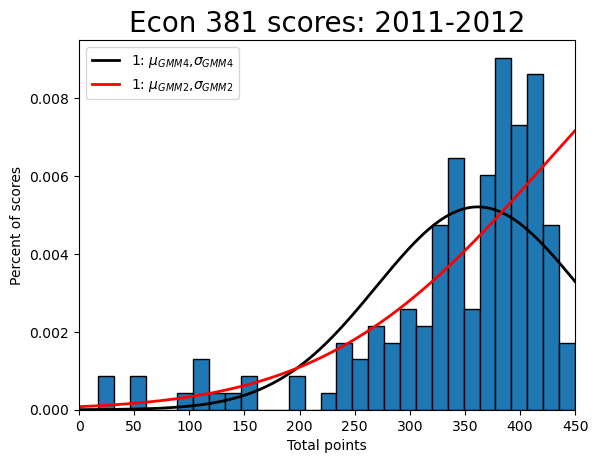

In [13]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title('Econ 381 scores: 2011-2012', fontsize=20)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent of scores')
plt.xlim([0, 450])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 450, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM1_4, sig_GMM1_4, 0.0, 450),
         linewidth=2, color='k', label='1: $\mu_{GMM4}$,$\sigma_{GMM4}$')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 450, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 450),
         linewidth=2, color='red', label='1: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

## 3.3: Remember the gradient!!!

Let's return to the two-moment estimator, to make the most important point of this entire TA session: **the importance of the gradient**. Looking at the code again, we notice that that our call to scipy.optimize.minimize() is not passing the gradient of the criterion function. That means the optimizer is relying on numerical approximations of the gradient.

In [14]:
mu_init = 400
sig_init = 60
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, 0.0, 450.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))

In this simple case, the gradient is smooth, so numerical approximations are sufficient. **That's won't usually be the case; in general, you should always provide a direct calculation of the gradient to your optimizer**. This is simple enough to do, since earlier to recover GMM SEs we wrote a function that calculated the Jacobian $d(x|\hat{\theta}_{GMM})$ of the moment error vector $e(x|\hat{\theta}_{GMM})$. We can use this function and chain rule to calculate the gradient of the criterion function.

In [15]:
def criterion_gradient(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    Jac_err = Jac_err2(xvals, mu, sigma, cut_lb, cut_ub)
    crit_grad = (2 * Jac_err.T @ W @ err)
    
    return crit_grad

results_grad = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, jac=criterion_gradient, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))

results.x, results_grad.x

(array([622.04529856, 198.72061651]), array([622.04531592, 198.72062092]))

And we see that results correspond, meaning our gradient is correct. Again, while it may seem trivial in this case, this is **essential** for convergence when dealing with a poorly behaved objective function. Which is precisely what you'll be facing!

# 4: General tips

1. **Always provide the gradient**.
2. Don't rely on built-in functions; i.e. write your own OLS function directly multiplying the matrices, instead of using statsmodels. This will (1) ensure you understand the underlying math, making it easier to derive the gradient, and (2) help with speeding up code when needed (i.e. JIT compiling).
3. Very basic, but break up your code into functions! Good coding practice and will make getting started easier/less daunting. 

# References
* Adda, Jerome and Russell Cooper, *Dynamic Economics: Quantitative Methods and Applications*, MIT Press (2003).
* Brock, William A. and Leonard J. Mirman, "Optimal Economic Growth and Uncertainty: The Discounted Case," *Journal of Economic Theory*, 4:3, pp. 479-513 (June 1972).
* Davidson, Russell and James G. MacKinnon, *Econometric Theory and Methods*, Oxford University Press (2004).
* Fuhrer, Jeffrey C., George R. Moore, and Scott D. Schuh, "Estimating the Linear-quadratic Inventory Model: Maximum Likelihood versus Generalized Method of Moments," *Journal of Monetary Economics*, 35:1, pp. 115-157 (February 1995).
* Hansen, Lars Peter, "Large Sample Properties of Generalized Method of Moments Estimators," *Econometrica*, 50:4, pp. 1029-1054 (July 1982).
* Hansen, Lars Peter and Kenneth J. Singleton, "Generalized Instrumental Variables Estimation of Nonlinear Rational Expectations Models", *Econometrica*, 50:5, pp. 1269-1286 (September 1982).
* Newey, Whitney K. and Kenneth D. West, "A Simple, Positive, Semi-definite, Heteroskedasticy and Autocorrelation Consistent Covariance Matrix," *Econometrica*, 55:3, pp. 703-708 (May 1987).